In [1]:
import sys
sys.path.append('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/00_Codes/sleepyspike')
import sleepyspike.sleepscoring as slpysc
import sleepyspike.lfpanalysis as slpylfp
import sleepyspike.reactivation as slpyreact
import sleepyspike.lfpspike as slpylfpspike

import os
import glob
import h5py
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import mlab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import math
import scipy
import scipy.io
from scipy import signal, stats
from scipy.stats import t, sem, zscore
import scikit_posthocs as sp
import pandas as pd
import pickle
import matplotlib as mpl

import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
metainfo_list = glob.glob('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/TM*/*_smp*/metainfo.h5')

res_Dir = os.getcwd()+'/Results'
os.makedirs(res_Dir, exist_ok=True)

In [3]:
session_info = []
for i in range(len(metainfo_list)):
    metainfo = h5py.File(metainfo_list[i], 'r')
    session_info.append(metainfo['general/mouseID'].value)
    session_info.append(metainfo_list[i].replace('/metainfo.h5',''))
    session_info.append(metainfo['general/sessionNo'].value)
    session_info.append(metainfo['general/sessionType'].value)
    session_info.append(metainfo['general/condition'].value)
    metainfo.flush()
    metainfo.close()

session_info = pd.DataFrame(np.array(session_info).reshape((int(len(session_info)/5),5)), columns=['mouseID','sessionDir','sessionNo','sessionType','condition'])
session_info.set_index('mouseID', inplace=True)
display(session_info)

,sessionDir,sessionNo,sessionType,condition
mouseID,,,,
TM015,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session11,sampling,w/ female
TM016,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session18,sampling,w/o female
TM018,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session07,sampling,w/ female
TM019,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session08,sampling,w/o female
TM020,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session04,sampling,w/ female
TM022,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session05,sampling,w/o female
TM023,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session03,sampling,w/o female
TM025,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session03,sampling,w/ female
TM027,/home/ysaito/Synology/Saito/Tetrode/02_Analysi...,session05,sampling,w/o female


In [4]:
classified_unit =  pd.read_csv('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/Analysis_all/01_UnitProcess/unit_features_all.csv')

In [5]:
mouse_list_good=[]
for i in session_info.index:
    if len(np.array(classified_unit[classified_unit['mouseID']==i][classified_unit['region']=='BLA'][classified_unit['location']==True]))!=0:
        mouse_list_good.append(i)
print(mouse_list_good)

['TM015', 'TM019', 'TM020', 'TM023', 'TM025', 'TM027', 'TM028', 'TM029', 'TM033', 'TM035', 'TM037', 'TM038', 'TM039']


In [6]:
mouseID_wf = []
mouseID_wof = []
for i in mouse_list_good:
    if session_info.loc[i]['condition'] == 'w/ female':
        mouseID_wf.append(i)
    else:
        mouseID_wof.append(i)
mouseID_wf = np.array(mouseID_wf)
mouseID_wof = np.array(mouseID_wof)
print('w/ female condition:',mouseID_wf)
print('w/o female condition:',mouseID_wof)

w/ female condition: ['TM015' 'TM020' 'TM025' 'TM028' 'TM033' 'TM037']
w/o female condition: ['TM019' 'TM023' 'TM027' 'TM029' 'TM035' 'TM038' 'TM039']


In [7]:
def binrasterLoad(mouseID, region, binraster_Dir, unitType):
    with open(binraster_Dir+ '/'+mouseID+'_binraster.pkl', 'rb') as f:
        binraster_ =  pickle.load(f)
        binraster_RS = {}
        if binraster_[region +'_RS'] != []:
            nonfiring_id = np.where(np.sum(np.array(list(binraster_[region +'_RS']['Task'].values())),axis=1)==0)[0]
            for i in binraster_[region +'_RS'].keys():
                tmp = {i: np.delete(np.array(list(binraster_[region +'_RS'][i].values())), nonfiring_id, axis=0)}
                binraster_RS.update(tmp)
            # binraster=binraster_RS
            print(mouseID,region +'_RS', binraster_RS['Task'].shape[0])
        else:
            print(mouseID,region +'_RS', 'No units')
            
        binraster_FS = {}        
        if binraster_[region +'_FS'] != []:
            nonfiring_id = np.where(np.sum(np.array(list(binraster_[region +'_FS']['Task'].values())),axis=1)==0)[0]
            for i in binraster_[region +'_FS'].keys():
                tmp = {i: np.delete(np.array(list(binraster_[region +'_FS'][i].values())), nonfiring_id, axis=0)}
                binraster_FS.update(tmp)
            print(mouseID,region +'_FS', binraster_FS['Task'].shape[0])
        else:
            print(mouseID,region +'_FS', 'No units')

        if (binraster_RS != {}) & (binraster_FS != {}):
            if unitType == 'RS':
                binraster=binraster_RS
            elif unitType == 'FS':
                binraster=binraster_FS
            else:
                binraster = {}
                for i in binraster_RS.keys():
                    tmp = {i: np.vstack([binraster_RS[i],binraster_FS[i]])}
                    binraster.update(tmp)
                    
        elif (binraster_RS != {}) & (binraster_FS == {}):
            if unitType == 'FS':
                binraster = []
                print(mouseID,region +'_FS', 'No units')
            else:
                binraster=binraster_RS
                
        elif (binraster_RS == {}) & (binraster_FS != {}):
            if unitType == 'RS':
                binraster = []
                print(mouseID,region +'_RS', 'No units')
            else:
                binraster=binraster_FS
        else:
            binraster = []
            print('No '+region+ ' units')
    
    return binraster

In [19]:
def AssemblyWeight(Qref):
    '''
        This function returns normarized weight vectors of the assembly patterns
        Parameters
        ----------
        Qref: binned spike trains during reference epoch
    '''    
    from sklearn.decomposition import FastICA
    
    Qref = stats.zscore(Qref, axis=1)
    nCells = len(Qref)
    
    def pcacov(C):
        lambdas, PCs = np.linalg.eigh(C)
        for i in range(len(PCs[0])):
            if PCs[:,i][np.argmax(abs(PCs[:,i]))] < 0:
                PCs[:,i] = PCs[:,i]*-1
        PCs = np.fliplr(PCs)
        PCs = np.round(PCs, 4)
        return lambdas, PCs

    Cref = np.corrcoef(Qref);
    lambdas, PCs = pcacov(Cref);

    lMax = (1 + math.sqrt(nCells / len(Qref[1])))**2
    nPCs = sum(lambdas>lMax);
    if nPCs > 0:
        phi = lambdas[np.array(np.where(lambdas>lMax)).min():np.array(np.where(lambdas>lMax)).max()+1]/lMax
        phi = phi[::-1]
        PCs = PCs[:,:nPCs]
        ##van de Ven et al 2016
        Zproj = Qref.T.dot(PCs)
        ica = FastICA(max_iter=500000)
        source = ica.fit_transform(Zproj) # Reconstruct signals
        icaW = ica._unmixing.T  # Get estimated unmixing matrix
        Vec=(PCs.dot(icaW)) #weight vectors of the assembly patterns
        #nW=Vec/(np.sqrt(sum(np.multiply(Vec, Vec)))) #normalized by unit length
        nW=Vec/np.sqrt(sum(Vec**2))
        for i in range(len(nW[0])):
            if nW[:,i][np.argmax(abs(nW[:,i]))] < 0:
                nW[:,i] = nW[:,i]*-1
    else:
        print('no significant PCs')
        nW=np.zeros([Qref.shape[0],1])
    return nW

In [20]:
def AssemblyStrength(nW, Qtar):
    '''
        This function returns assembly strength
        Parameters
        ----------
        nW: normilized weight vector
        Qtar: binned spike trains during target epoch
    '''    
## RnR_methods        
    # get assembly strength for each template across time bins
    
    #Qtar = Qtar/0.025
    Qtar = stats.zscore(Qtar.T)
    
    scoreTar = Qtar.dot(nW)

    # this trick is used to get rid of the diagonal term in react. strength
    tmp = np.dot(np.multiply(Qtar, Qtar),np.multiply(nW, nW))
    tmp2 = np.multiply(scoreTar, scoreTar)
    react = tmp2 - tmp 

## Miyawaki et al 2021
    # Qtar = stats.zscore(Qtar, axis=1)
    # react = []
    # for k in range(len(nW[0])):
    #     Pk = np.outer(nW[:,k], nW[:,k])
    #     Pk[[range(len(nW)), range(len(nW))]] = 0
    #     Rk = Qtar.T.dot(Pk)*Qtar.T
    #     Rk = np.sum(Rk, axis=1)
    #     react.append(Rk)
    # react = np.array(react).T
    
    return react

In [21]:
def ActivationRatePeakAll(mouseID_list, AssemblyStrength_all, binwidth):
    def ActivationRatePeak(R, binned_rate):
        act_rate = []
        act_peak = []
        for k in range(R.shape[1]):
            a = np.where(R[:,k]>5)[0] # threshold 5
            #remove serial indices
            b = np.delete(a, -1)
            c = np.insert(b, 0, 0)
            d = a - c
            reactTiming = a[np.where(d > 1)[0]]
            temp_rate = (reactTiming.shape[0]/R.shape[0])*binned_rate*60 # reactivations / min 
            temp_peak = np.mean(R[:,k][reactTiming])
            act_rate.append(temp_rate)
            act_peak.append(temp_peak)
        return act_rate,act_peak
    
    
    binned_rate = 1/binwidth
    PRE_NREM_rate_all = []
    PRE_NREM_peak_all = []
    POST_NREM_rate_all = []
    POST_NREM_peak_all = []
    POST_NREM_rate_2_all = []
    POST_NREM_peak_2_all = []
    PRE_REM_rate_all = []
    PRE_REM_peak_all = []
    POST_REM_rate_all = []
    POST_REM_peak_all = []
    for mouseID in mouseID_list:
        if np.isnan(AssemblyStrength_all[mouseID]['Task']).any() != True:
            PRE_NREM_rate, PRE_NREM_peak = ActivationRatePeak(AssemblyStrength_all[mouseID]['PRE_NREM'], binned_rate)
            POST_NREM_rate, POST_NREM_peak = ActivationRatePeak(AssemblyStrength_all[mouseID]['POST_NREM'][0:int(1800*binned_rate)], binned_rate)
            POST_NREM_rate_2, POST_NREM_peak_2 = ActivationRatePeak(AssemblyStrength_all[mouseID]['POST_NREM'][int(1800*binned_rate):], binned_rate)
            PRE_REM_rate, PRE_REM_peak = ActivationRatePeak(AssemblyStrength_all[mouseID]['PRE_REM'], binned_rate)
            POST_REM_rate, POST_REM_peak = ActivationRatePeak(AssemblyStrength_all[mouseID]['POST_REM'], binned_rate)

            PRE_NREM_rate_all.append(PRE_NREM_rate)
            POST_NREM_rate_all.append(POST_NREM_rate)
            POST_NREM_rate_2_all.append(POST_NREM_rate_2)
            PRE_REM_rate_all.append(PRE_REM_rate)
            POST_REM_rate_all.append(POST_REM_rate)
            
            PRE_NREM_peak_all.append(PRE_NREM_peak)
            POST_NREM_peak_all.append(POST_NREM_peak)
            POST_NREM_peak_2_all.append(POST_NREM_peak_2)
            PRE_REM_peak_all.append(PRE_REM_peak)
            POST_REM_peak_all.append(POST_REM_peak)
            
    PRE_NREM_rate_all = sum(PRE_NREM_rate_all, [])
    POST_NREM_rate_all = sum(POST_NREM_rate_all, [])
    POST_NREM_rate_2_all = sum(POST_NREM_rate_2_all, [])
    PRE_REM_rate_all = sum(PRE_REM_rate_all, [])
    POST_REM_rate_all = sum(POST_REM_rate_all, [])

    PRE_NREM_peak_all = sum(PRE_NREM_peak_all, [])
    POST_NREM_peak_all = sum(POST_NREM_peak_all, [])
    POST_NREM_peak_2_all = sum(POST_NREM_peak_2_all, [])
    PRE_REM_peak_all = sum(PRE_REM_peak_all, [])
    POST_REM_peak_all = sum(POST_REM_peak_all, [])
            
    activationRatePeakAll = pd.DataFrame({'activation rate':{'PRE NREM':PRE_NREM_rate_all, 'POST NREM':POST_NREM_rate_all, 'POST NREM2': POST_NREM_rate_2_all,
                                      'PRE REM':PRE_REM_rate_all, 'POST REM':POST_REM_rate_all},
                                      'activation peak':{'PRE NREM':PRE_NREM_peak_all, 'POST NREM':POST_NREM_peak_all, 'POST NREM2': POST_NREM_peak_2_all,
                                      'PRE REM':PRE_REM_peak_all, 'POST REM':POST_REM_peak_all}})

    return activationRatePeakAll

In [22]:
def binnedReactRate(Assembly_all, mouseID_list, binwidth, epoch, Type):
    binrate=1/binwidth
    calcwidth=int(binrate*60) #1min

    binnedReactRate_all = []
    for mouseID in mouseID_list:
        react_rate = []
        for asmblyID in Assembly_all[mouseID].keys():
            if Assembly_all[mouseID][asmblyID]['Type']==Type:
                reactivation=Assembly_all[mouseID][asmblyID][epoch]
                react_rate=[]
                a = reactivation[:(reactivation.size//calcwidth)*calcwidth].reshape(-1, calcwidth)
                react_rate_tmp=[]
                for k in range(len(a)):
                    b = np.where(a[k]>5)[0] # threshold 5
                    #remove serial indices
                    if b != []:
                        c = np.delete(b, -1)
                        d = np.insert(c, 0, 0)
                        e = b - d
                        reactTiming = b[np.where(e > 1)[0]]
                        react_rate_bin = len(reactTiming)
                        react_rate_tmp.append(react_rate_bin)
                    else:
                        react_rate_bin=0
                        react_rate_tmp.append(react_rate_bin)
                react_rate.append(react_rate_tmp)
            binnedReactRate_all.extend(react_rate)
    binnedReactRate_all=np.array(binnedReactRate_all)
    return binnedReactRate_all

In [23]:
def padding(X):
# X: 2D array

    ## Max size
    l = max(map(len, X))
    ## Padding
    X2 = np.zeros([len(X),l])
    for i in range(len(X)):
        X2[i] = np.pad(X[i],[0,l-len(X[i])])

    return X2

In [172]:
def ActivationRatePeakAll(AssemblyStrength, binwidth, state):
    def ActivationRatePeak(R, binned_rate):
        act_rate = []
        act_peak = []
        if state=='NREM':
            for k in range(R.shape[1]):
                a = np.where(R[:,k]>5)[0] # threshold 5
                #remove serial indices
                b = np.delete(a, -1)
                c = np.insert(b, 0, 0)
                d = a - c
                reactTiming = a[np.where(d > 1)[0]]
                temp_rate = (reactTiming.shape[0]/R.shape[0])*binned_rate*60 # reactivations / min 
                temp_peak = np.mean(R[:,k][reactTiming])
                act_rate.append(temp_rate)
                act_peak.append(temp_peak)
        else:
            for k in range(len(R)):
                a = np.where(R[k]>5)[0] # threshold 5
                #remove serial indices
                b = np.delete(a, -1)
                c = np.insert(b, 0, 0)
                d = a - c
                reactTiming = a[np.where(d > 1)[0]]
                temp_rate = (reactTiming.shape[0]/len(R[k]))*binned_rate*60 # reactivations / min 
                temp_peak = np.mean(R[k][reactTiming])
                act_rate.append(temp_rate)
                act_peak.append(temp_peak)            
        
        return act_rate,act_peak
    
    binned_rate = 1/binwidth
    #act_rate_all,act_peak_all=[],[]
    act_rate,act_peak = ActivationRatePeak(AssemblyStrength, binned_rate)

    return act_rate, act_peak

In [166]:
# binwidth = 0.025
# binraster_Dir = glob.glob('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/Analysis_All/01_UnitProcess/binraster_'+str(int(binwidth*1000))+'ms')[0]
# Assembly_all={}
# for mouseID in mouse_list_good:
#     print('')
#     print(mouseID)

#     # Load bin raster
#     binraster_BLA = binrasterLoad(mouseID = mouseID, region = 'BLA', binraster_Dir=binraster_Dir, unitType='All')
#     binraster_M2 = binrasterLoad(mouseID = mouseID, region = 'M2', binraster_Dir=binraster_Dir, unitType='All')
#     binraster_S1 = binrasterLoad(mouseID = mouseID, region = 'S1', binraster_Dir=binraster_Dir, unitType='All')

#     if (binraster_BLA!=[]) & (binraster_M2!=[]) & (binraster_S1!=[]):
#         Qref = np.vstack([binraster_BLA['Task'], binraster_M2['Task'], binraster_S1['Task']])
#         QpreNREM = np.vstack([binraster_BLA['PRE_NREM'], binraster_M2['PRE_NREM'], binraster_S1['PRE_NREM']])
#         QpreREM = np.vstack([binraster_BLA['PRE_REM'], binraster_M2['PRE_REM'], binraster_S1['PRE_REM']])
#         QpostNREM = np.vstack([binraster_BLA['POST_NREM'], binraster_M2['POST_NREM'], binraster_S1['POST_NREM']])
#         QpostREM = np.vstack([binraster_BLA['POST_REM'], binraster_M2['POST_REM'], binraster_S1['POST_REM']])
#         # BLA-M2-S1 neurons number
#         BLA_n = binraster_BLA['Task'].shape[0]
#         M2_n = binraster_M2['Task'].shape[0]
#         S1_n = binraster_S1['Task'].shape[0]
#         unit_region_num = {'BLA':BLA_n, 'M2':M2_n, 'S1': S1_n}

#     elif (binraster_BLA==[]) & (binraster_M2!=[]) & (binraster_S1!=[]):
#         Qref = np.vstack([binraster_M2['Task'], binraster_S1['Task']])
#         QpreNREM = np.vstack([binraster_M2['PRE_NREM'], binraster_S1['PRE_NREM']])
#         QpreREM = np.vstack([binraster_M2['PRE_REM'], binraster_S1['PRE_REM']])
#         QpostNREM = np.vstack([binraster_M2['POST_NREM'], binraster_S1['POST_NREM']])
#         QpostREM = np.vstack([binraster_M2['POST_REM'], binraster_S1['POST_REM']])
#         # M2-S1 neurons number
#         BLA_n = 0
#         M2_n = binraster_M2['Task'].shape[0]
#         S1_n = binraster_S1['Task'].shape[0]
#         unit_region_num = {'BLA':BLA_n, 'M2':M2_n, 'S1': S1_n}

#     elif (binraster_BLA!=[]) & (binraster_M2==[]) & (binraster_S1!=[]):
#         Qref = np.vstack([binraster_BLA['Task'], binraster_S1['Task']])
#         QpreNREM = np.vstack([binraster_BLA['PRE_NREM'], binraster_S1['PRE_NREM']])
#         QpreREM = np.vstack([binraster_BLA['PRE_REM'], binraster_S1['PRE_REM']])
#         QpostNREM = np.vstack([binraster_BLA['POST_NREM'], binraster_S1['POST_NREM']])
#         QpostREM = np.vstack([binraster_BLA['POST_REM'], binraster_S1['POST_REM']])
#         # BLA-S1 neurons number
#         BLA_n = binraster_BLA['Task'].shape[0]
#         M2_n = 0
#         S1_n = binraster_S1['Task'].shape[0]
#         unit_region_num = {'BLA':BLA_n, 'M2':M2_n, 'S1': S1_n}

#     elif (binraster_BLA!=[]) & (binraster_M2!=[]) & (binraster_S1==[]):
#         Qref = np.vstack([binraster_BLA['Task'], binraster_M2['Task']])
#         QpreNREM = np.vstack([binraster_BLA['PRE_NREM'], binraster_M2['PRE_NREM']])
#         QpreREM = np.vstack([binraster_BLA['PRE_REM'], binraster_M2['PRE_REM']])
#         QpostNREM = np.vstack([binraster_BLA['POST_NREM'], binraster_M2['POST_NREM']])
#         QpostREM = np.vstack([binraster_BLA['POST_REM'], binraster_M2['POST_REM']])
#         # BLA-M2 neurons number
#         BLA_n = binraster_BLA['Task'].shape[0]
#         M2_n = binraster_M2['Task'].shape[0]
#         S1_n = 0
#         unit_region_num = {'BLA':BLA_n, 'M2':M2_n, 'S1': S1_n}
        
#     elif (binraster_BLA!=[]) & (binraster_M2==[]) & (binraster_S1==[]):
#         Qref = binraster_BLA['Task']
#         QpreNREM = binraster_BLA['PRE_NREM']
#         QpreREM = binraster_BLA['PRE_REM']
#         QpostNREM = binraster_BLA['POST_NREM']
#         QpostREM = binraster_BLA['POST_REM']
#         # BLA neurons number
#         BLA_n = binraster_BLA['Task'].shape[0]
#         M2_n = 0
#         S1_n = 0
#         unit_region_num = {'BLA':BLA_n, 'M2':M2_n, 'S1': S1_n}

#     elif (binraster_BLA==[]) & (binraster_M2!=[]) & (binraster_S1==[]):
#         Qref = binraster_M2['Task']
#         QpreNREM = binraster_M2['PRE_NREM']
#         QpreREM = binraster_M2['PRE_REM']
#         QpostNREM = binraster_M2['POST_NREM']
#         QpostREM = binraster_M2['POST_REM']
#         # M2 neurons number
#         BLA_n = 0
#         M2_n = binraster_M2['Task'].shape[0]
#         S1_n = 0
#         unit_region_num = {'BLA':BLA_n, 'M2':M2_n, 'S1': S1_n}

#     elif (binraster_BLA==[]) & (binraster_M2==[]) & (binraster_S1!=[]):
#         Qref = binraster_S1['Task']
#         QpreNREM = binraster_S1['PRE_NREM']
#         QpreREM = binraster_S1['PRE_REM']
#         QpostNREM = binraster_S1['POST_NREM']
#         QpostREM = binraster_S1['POST_REM']
#         # S1 neurons number
#         BLA_n = 0
#         M2_n = 0
#         S1_n = binraster_S1['Task'].shape[0]
#         unit_region_num = {'BLA':BLA_n, 'M2':M2_n, 'S1': S1_n}

#     # detect neural assemblies    
#     nW = AssemblyWeight(Qref)
#     print('Assemblies:', nW.shape[1])

#     # define member neurons
#     member_idx = []
#     nonmeber_idx = []
#     for i in range(nW.shape[1]):
#         # threshold for member neurons: 1/sqrt(Number of neurons)
#         # Oberto et al., Curr. Bio., 2021
#         threshold = 1/math.sqrt(nW.shape[0])
#         tmp = np.where(abs(nW[:,i]) > threshold)[0]
#         tmp2 = np.where(abs(nW[:,i]) <= threshold)[0]
#         member_idx.append(tmp)
#         nonmeber_idx.append(tmp2)

#     Assembly = {}
#     for i in range(nW.shape[1]):
        
#         #BLA neurons weight to 0
#         #nW[:,i][BLA_n+M2_n:BLA_n+M2_n+S1_n]=0
        
#         #caclculate activation strength
#         Rref = AssemblyStrength(nW[:,i], Qref)
#         RpreNREM = AssemblyStrength(nW[:,i], QpreNREM[:,-int(900/binwidth):])
#         RpostNREM = AssemblyStrength(nW[:,i], QpostNREM[:,:int(3600/binwidth)])
#         RpreREM = AssemblyStrength(nW[:,i], QpreREM)
#         RpostREM = AssemblyStrength(nW[:,i], QpostREM)

#         #member region
#         BLA_neuron_idx = np.where(member_idx[i]<unit_region_num['BLA'])[0]
#         M2_neuron_idx = np.where((unit_region_num['BLA']<=member_idx[i]) & (member_idx[i]<unit_region_num['BLA']+unit_region_num['M2']))[0]
#         S1_neuron_idx = np.where((unit_region_num['BLA']+unit_region_num['M2']<=member_idx[i]) & (member_idx[i]<unit_region_num['BLA']+unit_region_num['M2']+unit_region_num['S1']))[0]
#         member_region = {'BLA':member_idx[i][BLA_neuron_idx], 'M2':member_idx[i][M2_neuron_idx], 'S1':member_idx[i][S1_neuron_idx]}
#         #assembly type
#         if (BLA_neuron_idx.shape[0] != 0) & (M2_neuron_idx.shape[0] != 0) & (S1_neuron_idx.shape[0] != 0):
#             Type = 'BLA-M2-S1'
#         elif (BLA_neuron_idx.shape[0] == 0) & (M2_neuron_idx.shape[0] != 0) & (S1_neuron_idx.shape[0] != 0):
#             Type = 'M2-S1'
#         elif (BLA_neuron_idx.shape[0] != 0) & (M2_neuron_idx.shape[0] == 0) & (S1_neuron_idx.shape[0] != 0):
#             Type = 'BLA-S1'
#         elif (BLA_neuron_idx.shape[0] != 0) & (M2_neuron_idx.shape[0] != 0) & (S1_neuron_idx.shape[0] == 0):
#             Type = 'BLA-M2'
#         elif (BLA_neuron_idx.shape[0] != 0) & (M2_neuron_idx.shape[0] == 0) & (S1_neuron_idx.shape[0] == 0):
#             Type = 'BLA'    
#         elif (BLA_neuron_idx.shape[0] == 0) & (M2_neuron_idx.shape[0] != 0) & (S1_neuron_idx.shape[0] == 0):
#             Type = 'M2'    
#         elif (BLA_neuron_idx.shape[0] == 0) & (M2_neuron_idx.shape[0] == 0) & (S1_neuron_idx.shape[0] != 0):
#             Type = 'S1'           
#         #non-member region
#         BLA_neuron_idx = np.where(nonmeber_idx[i]<unit_region_num['BLA'])[0]
#         M2_neuron_idx = np.where((unit_region_num['BLA']<=nonmeber_idx[i]) & (nonmeber_idx[i]<unit_region_num['BLA']+unit_region_num['M2']))[0]
#         S1_neuron_idx = np.where((unit_region_num['BLA']+unit_region_num['M2']<=nonmeber_idx[i]) & (nonmeber_idx[i]<unit_region_num['BLA']+unit_region_num['M2']+unit_region_num['S1']))[0]
#         nonmember_region = {'BLA':nonmeber_idx[i][BLA_neuron_idx], 'M2':nonmeber_idx[i][M2_neuron_idx], 'S1':nonmeber_idx[i][S1_neuron_idx]}


#         Assembly.update({i:{'Weight':nW[:,i] ,'Rref':Rref, 'RpreNREM':RpreNREM, 'RpostNREM':RpostNREM, 'RpreREM':RpreREM, 'RpostREM':RpostREM, 
#                             'unit_region_N':unit_region_num, 'member':member_region, 'nonmember':nonmember_region, 'Type':Type}}) 
    
#     Assembly_all.update({mouseID: Assembly})


TM015
TM015 BLA_RS 25
TM015 BLA_FS No units
TM015 M2_RS 8
TM015 M2_FS No units
TM015 S1_RS 10
TM015 S1_FS 1
Assemblies: 8

TM019
TM019 BLA_RS 14
TM019 BLA_FS 2
TM019 M2_RS No units
TM019 M2_FS No units
No M2 units
TM019 S1_RS 1
TM019 S1_FS 4
Assemblies: 4

TM020
TM020 BLA_RS 7
TM020 BLA_FS No units
TM020 M2_RS 2
TM020 M2_FS No units
TM020 S1_RS 11
TM020 S1_FS 1
Assemblies: 4

TM023
TM023 BLA_RS 7
TM023 BLA_FS No units
TM023 M2_RS No units
TM023 M2_FS No units
No M2 units
TM023 S1_RS No units
TM023 S1_FS 1
Assemblies: 1

TM025
TM025 BLA_RS 6
TM025 BLA_FS No units
TM025 M2_RS No units
TM025 M2_FS No units
No M2 units
TM025 S1_RS No units
TM025 S1_FS No units
No S1 units
Assemblies: 1

TM027
TM027 BLA_RS 2
TM027 BLA_FS 1
TM027 M2_RS 12
TM027 M2_FS No units
TM027 S1_RS 1
TM027 S1_FS 1
Assemblies: 5

TM028
TM028 BLA_RS 8
TM028 BLA_FS No units
TM028 M2_RS 4
TM028 M2_FS 2
TM028 S1_RS 11
TM028 S1_FS 1
Assemblies: 5

TM029
TM029 BLA_RS 14
TM029 BLA_FS No units
TM029 M2_RS 7
TM029 M2_FS No unit

In [183]:
# f_name = res_Dir+'/Assemblies.pkl'
# with open(f_name, mode='wb') as f:
#     pickle.dump(Assembly_all,f)

In [184]:
f_name = os.getcwd()+'/Results/Assemblies.pkl'
with open(f_name, mode='rb') as f:
    Assembly_all = pickle.load(f)

In [168]:
# binwidth = 0.025
# activationRatePeakAll_wo = ActivationRatePeakAll(mouseID_wof, TripleAssembly['Strength'], binwidth=binwidth)
# activationRatePeakAll_w = ActivationRatePeakAll(mouseID_wf, TripleAssembly['Strength'],binwidth=binwidth)

In [241]:
count_BLA_M2_S1 = 0
count_BLA_M2 = 0
count_BLA_S1 = 0
count_BLA = 0
count_M2_S1 = 0
count_M2 = 0
count_S1 = 0
for mouseID in mouseID_wf:
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-M2-S1':
            count_BLA_M2_S1=count_BLA_M2_S1+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-M2':
            count_BLA_M2=count_BLA_M2+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-S1':
            count_BLA_S1=count_BLA_S1+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'BLA':
            count_BLA=count_BLA+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'M2-S1':
            count_M2_S1=count_M2_S1+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'M2':
            count_M2=+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'S1':
            count_S1=count_M2+1
print('BLA-M2-S1:',count_BLA_M2_S1,'BLA-M2:',count_BLA_M2,'BLA-S1:',count_BLA_S1,'M2-S1:',count_M2_S1, 'BLA:',count_BLA,'M2:',count_M2,'S1:',count_S1)
print('total assemblies', np.sum([count_BLA_M2_S1,count_BLA_M2,count_BLA_S1,count_BLA, count_M2_S1, count_M2, count_S1]))
print('triple assembly ratio',count_BLA_M2_S1/np.sum([count_BLA_M2_S1,count_BLA_M2,count_BLA_S1,count_BLA, count_M2_S1, count_M2, count_S1]))

BLA-M2-S1: 17 BLA-M2: 2 BLA-S1: 6 M2-S1: 5 BLA: 1 M2: 1 S1: 0
total assemblies 32
triple assembly ratio 0.53125


In [187]:
count_BLA_M2_S1 = 0
count_BLA_M2 = 0
count_BLA_S1 = 0
count_BLA = 0
count_M2_S1 = 0
count_M2 = 0
count_S1 = 0
for mouseID in mouseID_wof:
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-M2-S1':
            count_BLA_M2_S1=count_BLA_M2_S1+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-M2':
            count_BLA_M2=count_BLA_M2+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-S1':
            count_BLA_S1=count_BLA_S1+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'BLA':
            count_BLA=count_BLA+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'M2-S1':
            count_M2_S1=count_M2_S1+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'M2':
            count_M2=+1
        elif Assembly_all[mouseID][asmblyID]['Type'] == 'S1':
            count_S1=count_M2+1
print('BLA-M2-S1:',count_BLA_M2_S1,'BLA-M2:',count_BLA_M2,'BLA-S1:',count_BLA_S1,'M2-S1:',count_M2_S1, 'BLA:',count_BLA,'M2:',count_M2,'S1:',count_S1)
print('total assemblies', np.sum([count_BLA_M2_S1,count_BLA_M2,count_BLA_S1,count_BLA, count_M2_S1, count_M2, count_S1]))
print('triple assembly ratio',count_BLA_M2_S1/np.sum([count_BLA_M2_S1,count_BLA_M2,count_BLA_S1,count_BLA, count_M2_S1, count_M2, count_S1]))

BLA-M2-S1: 9 BLA-M2: 1 BLA-S1: 4 M2-S1: 2 BLA: 2 M2: 1 S1: 2
total assemblies 21
triple assembly ratio 0.42857142857142855


In [171]:
#NREM
RpostNREM_wf=[]
for mouseID in mouseID_wf:
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type']=='BLA-M2-S1':
            RpostNREM_wf.append(Assembly_all[mouseID][asmblyID]['RpostNREM'])
RpostNREM_wof=[]
for mouseID in mouseID_wof:
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type']=='BLA-M2-S1':
            RpostNREM_wof.append(Assembly_all[mouseID][asmblyID]['RpostNREM'])
RpostNREM_wf=np.array(RpostNREM_wf)
RpostNREM_wof=np.array(RpostNREM_wof)

#REM
RpostREM_wf=[]
for mouseID in mouseID_wf:
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type']=='BLA-M2-S1':
            RpostREM_wf.append(Assembly_all[mouseID][asmblyID]['RpostREM'])
RpostREM_wof=[]
for mouseID in mouseID_wof:
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type']=='BLA-M2-S1':
            RpostREM_wof.append(Assembly_all[mouseID][asmblyID]['RpostREM'])
RpostREM_wf=np.array(RpostREM_wf)
RpostREM_wof=np.array(RpostREM_wof)

In [173]:
PostNREM_rate_wf, PostNREM_peak_wf = ActivationRatePeakAll(RpostNREM_wf[:,:1800*40].T, binwidth=binwidth, state='NREM')
PostNREM_rate_wof, PostNREM_peak_wof = ActivationRatePeakAll(RpostNREM_wof[:,:1800*40].T, binwidth=binwidth,  state='NREM')
PostNREM_rate_wf_2, PostNREM_peak_wf_2 = ActivationRatePeakAll(RpostNREM_wf[:,1800*40:3600*40].T, binwidth=binwidth, state='NREM')
PostNREM_rate_wof_2, PostNREM_peak_wof_2 = ActivationRatePeakAll(RpostNREM_wof[:,1800*40:3600*40].T, binwidth=binwidth,  state='NREM')
PostREM_rate_wf, PostREM_peak_wf = ActivationRatePeakAll(RpostREM_wf.T, binwidth=binwidth, state='REM')
PostREM_rate_wof, PostREM_peak_wof = ActivationRatePeakAll(RpostREM_wof.T, binwidth=binwidth,  state='REM')

In [232]:
Type='BLA-M2-S1'
binnedReactRate_NREM_wo = binnedReactRate(Assembly_all, mouseID_list=mouseID_wof, binwidth=binwidth, epoch='RpostNREM', Type=Type)
binnedReactRate_NREM_w = binnedReactRate(Assembly_all, mouseID_list=mouseID_wf, binwidth=binwidth, epoch='RpostNREM', Type=Type)

binnedReactRate_REM_wo = binnedReactRate(Assembly_all, mouseID_list=mouseID_wof, binwidth=binwidth, epoch='RpostREM', Type=Type)
binnedReactRate_REM_w = binnedReactRate(Assembly_all, mouseID_list=mouseID_wf, binwidth=binwidth, epoch='RpostREM', Type=Type)
binnedReactRate_REM_wo = padding(binnedReactRate_REM_wo)
binnedReactRate_REM_w = padding(binnedReactRate_REM_w)

In [174]:
print('NREM 0-30 min')
print('react. rate',stats.mannwhitneyu(PostNREM_rate_wof,PostNREM_rate_wf))
print('react. peak',stats.mannwhitneyu(PostNREM_peak_wof,PostNREM_peak_wf))

print('NREM 30-60 min')
print('react. rate',stats.mannwhitneyu(PostNREM_rate_wof_2,PostNREM_rate_wf_2))
print('react. peak',stats.mannwhitneyu(PostNREM_peak_wof_2,PostNREM_peak_wf_2))

print('REM')
print('react. rate',stats.mannwhitneyu(PostREM_rate_wof,PostREM_rate_wf))
print('react. peak',stats.mannwhitneyu(PostREM_peak_wof,PostREM_peak_wf))

NREM 0-30 min
react. rate MannwhitneyuResult(statistic=24.0, pvalue=0.002534358619877636)
react. peak MannwhitneyuResult(statistic=47.0, pvalue=0.059025431684588764)
NREM 30-60 min
react. rate MannwhitneyuResult(statistic=72.0, pvalue=0.4146547583796293)
react. peak MannwhitneyuResult(statistic=63.0, pvalue=0.24175808904257567)
REM
react. rate MannwhitneyuResult(statistic=66.0, pvalue=0.29492265472612555)
react. peak MannwhitneyuResult(statistic=52.0, pvalue=0.09791505961498298)


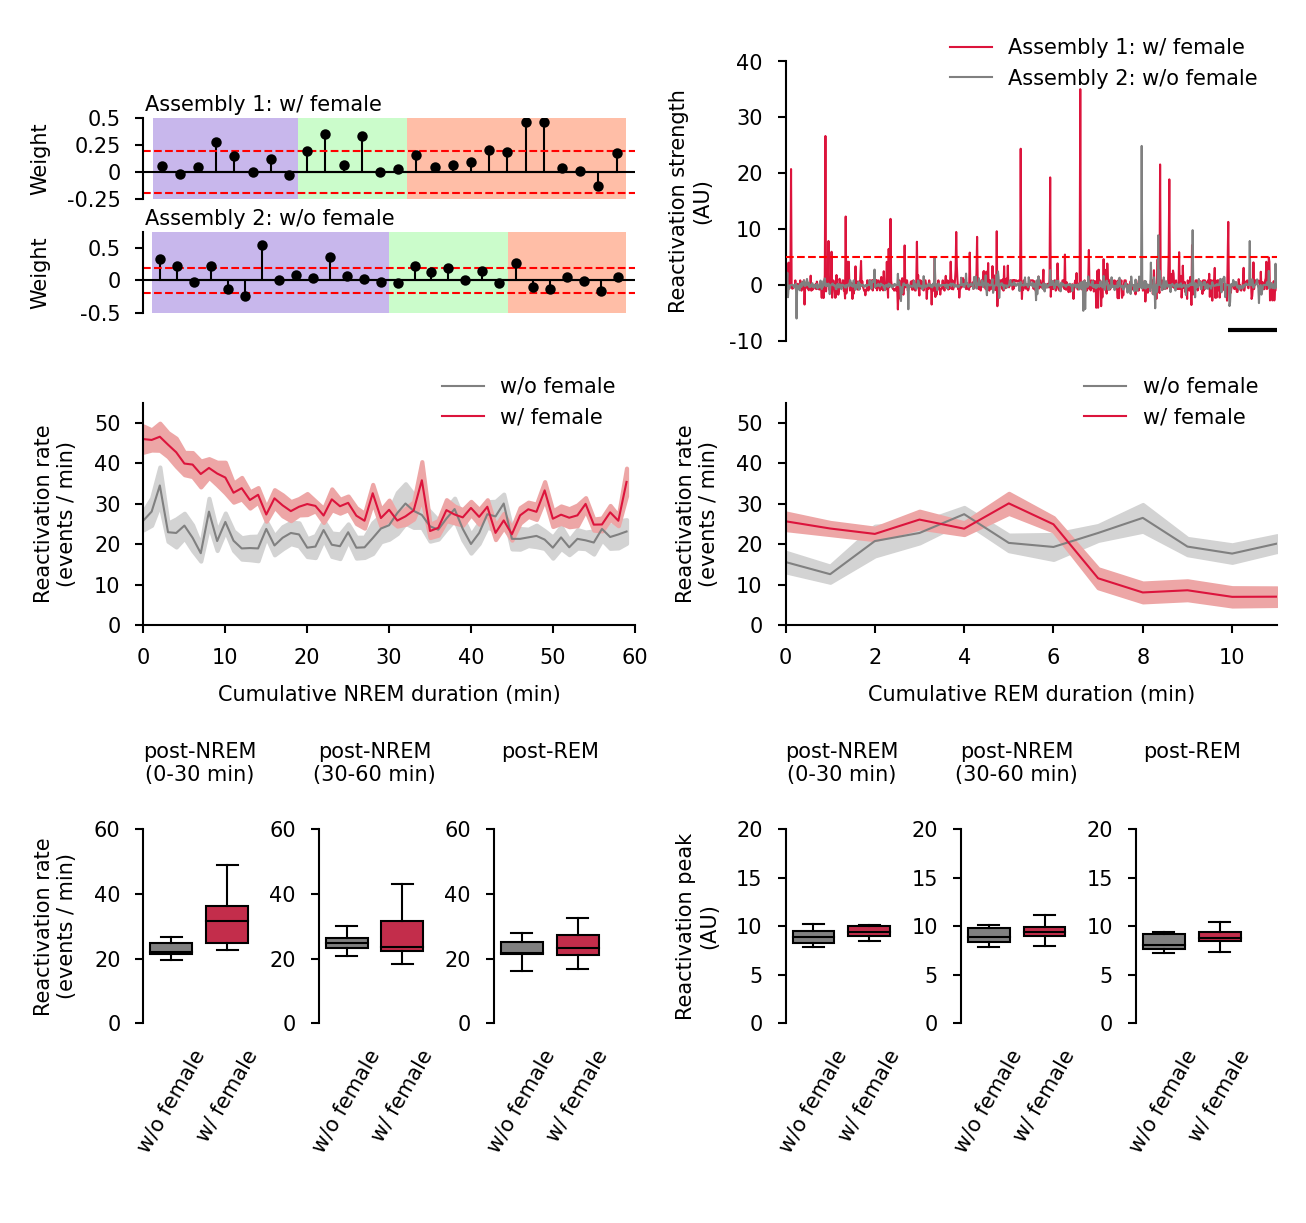

In [308]:
color=['gray','crimson']
sns.set_palette(color)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['axes.edgecolor']='black'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.labelsize']=5
mpl.rcParams['axes.titlesize']=5
mpl.rcParams['legend.fontsize']=5
mpl.rcParams['xtick.labelsize']=5
mpl.rcParams['ytick.labelsize']=5
mpl.rcParams['text.color']='black'
mpl.rcParams['lines.color']='black'
mpl.rcParams['xtick.color']='black'
mpl.rcParams['ytick.color']='black'
mpl.rcParams['axes.labelcolor']='black'

fig = plt.figure(figsize=(5,5),tight_layout=True)
gs = fig.add_gridspec(40, 40)
ax1 = fig.add_subplot(gs[2:5, 0:17])

asbly_idx_1= 0
Weight = Assembly_all['TM028'][asbly_idx_1]['Weight']
BLA_region_idx = Assembly_all['TM028'][asbly_idx_1]['unit_region_N']['BLA']
M2_region_idx = BLA_region_idx+Assembly_all['TM028'][asbly_idx_1]['unit_region_N']['M2']
S1_region_idx = M2_region_idx+Assembly_all['TM028'][asbly_idx_1]['unit_region_N']['S1']

threshold = 1/math.sqrt(len(Weight))
markerline, stemline, baseline = plt.stem(range(len(Weight)), Weight,label='Assembly 1: w/ female')
plt.setp(markerline, marker='o', markeredgewidth=0.5, markersize=2, color='black', markerfacecolor='black', zorder=3)
plt.setp(stemline, color='black', zorder=2, linewidth=0.5)
plt.setp(baseline, color='black', zorder=1,linewidth=0.5)
plt.xlim(-1,len(Weight))
plt.ylim(-0.25,0.5)
plt.hlines(0,-1,len(Weight), color='black',linewidth=0.5)
plt.hlines(threshold,-1,50, color='red', linestyles='dashed',linewidth=0.5)
plt.hlines(-threshold,-1,50, color='red', linestyles='dashed',linewidth=0.5)
ax1.axvspan(-0.5, BLA_region_idx-0.5, color = "mediumpurple", alpha=0.5, lw=0)
ax1.axvspan(-0.5+BLA_region_idx, M2_region_idx-0.5, color = "palegreen", alpha=0.5, lw=0)
ax1.axvspan(-0.5+M2_region_idx, S1_region_idx-0.5, color = "coral", alpha=0.5, lw=0)
plt.xticks([])
plt.yticks([-0.25, 0 , 0.25, 0.5],[-0.25, 0 , 0.25, 0.5])
plt.ylabel('Weight')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.legend(loc='lower left', bbox_to_anchor=(0.05,0.81),frameon=False, handletextpad=-2, handlelength=0, scatterpoints=0,markerscale=0)


ax2 = fig.add_subplot(gs[6:9, 0:17])
asbly_idx_2=1
Weight = Assembly_all['TM029'][asbly_idx_2]['Weight']
BLA_region_idx = Assembly_all['TM029'][asbly_idx_2]['unit_region_N']['BLA']
M2_region_idx = BLA_region_idx+Assembly_all['TM029'][asbly_idx_2]['unit_region_N']['M2']
S1_region_idx = M2_region_idx+Assembly_all['TM029'][asbly_idx_2]['unit_region_N']['S1']

threshold = 1/math.sqrt(len(Weight))
markerline, stemline, baseline = plt.stem(range(len(Weight)), Weight,label='Assembly 2: w/o female')
plt.setp(markerline, marker='o', markeredgewidth=0.5, markersize=2, color='black', markerfacecolor='black', zorder=3)
plt.setp(stemline, color='black', zorder=2, linewidth=0.5)
plt.setp(baseline, color='black', zorder=1,linewidth=0.5)
plt.xlim(-1,len(Weight))
plt.ylim(-0.25,0.75)
plt.hlines(0,-1,len(Weight), color='black',linewidth=0.5)
plt.hlines(threshold,-1,50, color='red', linestyles='dashed',linewidth=0.5)
plt.hlines(-threshold,-1,50, color='red', linestyles='dashed',linewidth=0.5)
ax2.axvspan(-0.5, BLA_region_idx-0.5, color = "mediumpurple", alpha=0.5, lw=0)
ax2.axvspan(-0.5+BLA_region_idx, M2_region_idx-0.5, color = "palegreen", alpha=0.5, lw=0)
ax2.axvspan(-0.5+M2_region_idx, S1_region_idx-0.5, color = "coral", alpha=0.5, lw=0)
plt.xticks([])
plt.yticks([-0.5, 0, 0.5],[-0.5, 0 , 0.5])
plt.ylabel('Weight')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.legend(loc='lower left', bbox_to_anchor=(0.05,0.81),frameon=False, handletextpad=-2, handlelength=0, scatterpoints=0,markerscale=0)

fig.align_labels([ax1, ax2])


ax3 = fig.add_subplot(gs[0:10, 22:39])
binwidth = 0.025
time_NREM=np.arange(0,3600, binwidth)
plot_window = [0, 20] # sec
plt.plot(time_NREM,Assembly_all['TM028'][asbly_idx_1]['RpostNREM'],linewidth=0.5, color='crimson',zorder=1, label='Assembly 1: w/ female')
plt.plot(time_NREM,Assembly_all['TM029'][asbly_idx_2]['RpostNREM'],linewidth=0.5, color='gray',zorder=2, label='Assembly 2: w/o female')
plt.ylim(-10, 40)
plt.xlim(plot_window[0],plot_window[1])
plt.hlines(y=5, xmin=plot_window[0]/binwidth, xmax=plot_window[1]/binwidth, linewidth=0.5, color='red', linestyles='dashed',zorder=3)
plt.hlines(-8 ,plot_window[1]-2,plot_window[1], color='black',linewidth=1) # time scale bar 2sec
plt.ylabel('Reactivation strength\n(AU)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.gca().yaxis.set_ticks_position('left')
plt.yticks([-10, 0, 10, 20, 30, 40],[-10, 0, 10, 20, 30, 40])
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.15, 0.5, 1),frameon=False)

ax4 = fig.add_subplot(gs[12:20, 0:17])
plt.plot(np.mean(binnedReactRate_NREM_wo,axis=0), color='gray', label='w/o female', linewidth=0.5)
ax4.fill_between(np.arange(0,60,1), np.mean(binnedReactRate_NREM_wo,axis=0)-stats.sem(binnedReactRate_NREM_wo,axis=0),
                np.mean(binnedReactRate_NREM_wo,axis=0)+stats.sem(binnedReactRate_NREM_wo,axis=0), color='lightgray')
plt.plot(np.mean(binnedReactRate_NREM_w,axis=0),color='crimson', label='w/ female', linewidth=0.5)
ax4.fill_between(np.arange(0,60,1), np.mean(binnedReactRate_NREM_w,axis=0)-stats.sem(binnedReactRate_NREM_w,axis=0),
                np.mean(binnedReactRate_NREM_w,axis=0)+stats.sem(binnedReactRate_NREM_w,axis=0), color='#eda6a6')
plt.xlim(0,60)
plt.ylim(0,55)
plt.xlabel('Cumulative NREM duration (min)')
plt.ylabel('Reactivation rate\n(events / min)')
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.2, 0.5, 1),frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.yticks([0,10,20,30,40,50],[0,10,20,30,40,50]);

ax5 = fig.add_subplot(gs[12:20, 22:39])
plt.plot(np.mean(binnedReactRate_REM_wo,axis=0), color='gray',label='w/o female', linewidth=0.5)
ax5.fill_between(np.arange(0,len(binnedReactRate_REM_wo[0]),1), np.mean(binnedReactRate_REM_wo,axis=0)-stats.sem(binnedReactRate_REM_wo,axis=0),
                np.mean(binnedReactRate_REM_wo,axis=0)+stats.sem(binnedReactRate_REM_wo,axis=0), color='lightgray')
plt.plot(np.mean(binnedReactRate_REM_w,axis=0), color='crimson',label='w/ female', linewidth=0.5)
ax5.fill_between(np.arange(0,len(binnedReactRate_REM_w[0]),1), np.mean(binnedReactRate_REM_w,axis=0)-stats.sem(binnedReactRate_REM_w,axis=0),
                np.mean(binnedReactRate_REM_w,axis=0)+stats.sem(binnedReactRate_REM_w,axis=0), color='#eda6a6')
plt.xlim(0,11)
plt.ylim(0,55)
plt.xlabel('Cumulative REM duration (min)')
plt.ylabel('Reactivation rate\n(events / min)')
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0.2, 0.5, 1),frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.yticks([0,10,20,30,40,50],[0,10,20,30,40,50]);

boxprops = {'edgecolor': 'black', 'linewidth': 0.5}
lineprops = {'color': 'black', 'linewidth': 0.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75})

ax6 = fig.add_subplot(gs[27:34, 0:4])
df1 = pd.DataFrame({'Reactivation Rate': PostNREM_rate_wof})
df1['Condition'] = 'w/o female'
df2 = pd.DataFrame({'Reactivation Rate': PostNREM_rate_wf})
df2['Condition'] = 'w/ female'
df_all_NREM_0_30 = pd.concat([df1,df2])
sns.boxplot(x='Condition', y='Reactivation Rate', data=df_all_NREM_0_30, showfliers=False, **boxplot_kwargs, ax=ax6)
# sns.stripplot(x='Condition', y='Reactivation Rate', data=df_all_NREM_0_30, jitter=True, color='black', ax=ax6)
plt.ylim(0,60)
ax6.set_xlabel(' ')
ax6.set_ylabel('Reactivation rate\n(events / min)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.tick_params(axis='x', width=0)
plt.title('post-NREM\n(0-30 min)\n')
plt.xticks(rotation=60);

####
ax7 = fig.add_subplot(gs[27:34, 6:10])
df3 = pd.DataFrame({'Reactivation Rate': PostNREM_rate_wof_2})
df3['Condition'] = 'w/o female'
df4 = pd.DataFrame({'Reactivation Rate': PostNREM_rate_wf_2})
df4['Condition'] = 'w/ female'
df_all_NREM_30_60 = pd.concat([df3,df4])
sns.boxplot(x='Condition', y='Reactivation Rate', data=df_all_NREM_30_60, showfliers=False, **boxplot_kwargs, ax=ax7)
# sns.stripplot(x='Condition', y='Reactivation Rate', data=df_all_NREM_30_60, jitter=True, color='black', ax=ax7)
plt.ylim(0,60)
ax7.set_xlabel(' ')
ax7.set_ylabel(' ')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.tick_params(axis='x', width=0)
plt.title('post-NREM\n(30-60 min)\n')
plt.xticks(rotation=60);

ax8 = fig.add_subplot(gs[27:34, 12:16])
df5 = pd.DataFrame({'Reactivation Rate': PostREM_rate_wof})
df5['Condition'] = 'w/o female'
df6 = pd.DataFrame({'Reactivation Rate': PostREM_rate_wf})
df6['Condition'] = 'w/ female'
df_all_REM = pd.concat([df5,df6])
sns.boxplot(x='Condition', y='Reactivation Rate', data=df_all_REM, showfliers=False, **boxplot_kwargs, ax=ax8)
# sns.stripplot(x='Condition', y='Reactivation Rate', data=df_all_REM, jitter=True, color='black', ax=ax8)
plt.ylim(0,60)
ax8.set_xlabel(' ')
ax8.set_ylabel(' ')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.tick_params(axis='x', width=0)
plt.title('post-REM\n\n')
plt.xticks(rotation=60);

ax9 = fig.add_subplot(gs[27:34, 22:26])
df1 = pd.DataFrame({'Reactivation Peak': PostNREM_peak_wof})
df1['Condition'] = 'w/o female'
df2 = pd.DataFrame({'Reactivation Peak': PostNREM_peak_wf})
df2['Condition'] = 'w/ female'
df_all_NREM_0_30 = pd.concat([df1,df2])
sns.boxplot(x='Condition', y='Reactivation Peak', data=df_all_NREM_0_30, showfliers=False, **boxplot_kwargs, ax=ax9)
# sns.stripplot(x='Condition', y='Reactivation Rate', data=df_all_NREM_0_30, jitter=True, color='black', ax=ax9)
plt.ylim(0,20)
ax9.set_xlabel(' ')
ax9.set_ylabel('Reactivation peak\n(AU)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.tick_params(axis='x', width=0)
plt.title('post-NREM\n(0-30 min)\n')
plt.xticks(rotation=60);

ax10 = fig.add_subplot(gs[27:34, 28:32])
df3 = pd.DataFrame({'Reactivation Peak': PostNREM_peak_wof_2})
df3['Condition'] = 'w/o female'
df4 = pd.DataFrame({'Reactivation Peak': PostNREM_peak_wf_2})
df4['Condition'] = 'w/ female'
df_all_NREM_30_60 = pd.concat([df3,df4])
sns.boxplot(x='Condition', y='Reactivation Peak', data=df_all_NREM_30_60, showfliers=False, **boxplot_kwargs, ax=ax10)
# sns.stripplot(x='Condition', y='Reactivation Rate', data=df_all_NREM_30_60, jitter=True, color='black', ax=ax10)
plt.ylim(0,20)
ax10.set_xlabel(' ')
ax10.set_ylabel(' ')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.tick_params(axis='x', width=0)
plt.title('post-NREM\n(30-60 min)\n')
plt.xticks(rotation=60);

ax11 = fig.add_subplot(gs[27:34, 34:38])
df5 = pd.DataFrame({'Reactivation Peak': PostREM_peak_wof})
df5['Condition'] = 'w/o female'
df6 = pd.DataFrame({'Reactivation Peak': PostREM_peak_wf})
df6['Condition'] = 'w/ female'
df_all_REM = pd.concat([df5,df6])
sns.boxplot(x='Condition', y='Reactivation Peak', data=df_all_REM, showfliers=False, **boxplot_kwargs, ax=ax11)
# sns.stripplot(x='Condition', y='Reactivation Rate', data=df_all_REM, jitter=True, color='black', ax=ax11)
plt.ylim(0,20)
ax11.set_xlabel(' ')
ax11.set_ylabel(' ')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.tick_params(axis='x', width=0)
plt.title('post-REM\n\n')
plt.xticks(rotation=60);
plt.savefig(res_Dir+'/TripleRegionReactivation.pdf',dpi=fig.dpi,bbox_inches='tight')

In [233]:
def detectReactivation(R):
    a = np.where(R>5)[0] # threshold 5
    #remove serial indices
    b = np.delete(a, -1)
    c = np.insert(b, 0, 0)
    d = a - c
    React_Event = a[np.where(d > 1)[0]]
    return React_Event

In [269]:
def reactCorrelogram(binraster_A, binraster_B, React_Event, binwidth_react, binwidth_fine):
    #ver 2
    window=0.05
    nCells_A = binraster_A.shape[0]
    nCells_B = binraster_B.shape[0]


    React_Event_fine = (React_Event*binwidth_react/binwidth_fine).astype('int64')
    react_idx_fine = np.vstack([React_Event_fine, React_Event_fine+(binwidth_react/binwidth_fine)]).T.astype('int64')

    #delete index of outside window
    del_idx=np.where((react_idx_fine-(window/binwidth_fine))[:,0]<0)[0]
    react_idx_fine=np.delete(react_idx_fine,del_idx,0)
    del_idx=np.where((react_idx_fine+(window/binwidth_fine))[:,1]>len(binraster_A[0]))[0]
    react_idx_fine=np.delete(react_idx_fine,del_idx,0)

    #numbers of reactivation
    nReact = react_idx_fine.shape[0]
    #z-scoring
    binraster_B_z = stats.zscore(binraster_B, axis=1)
    #binraster_B_z = binraster_B
    #reference spike index within reactivations
    ref_spiketime = []
    for k in range(binraster_A.shape[0]):
        spiketime=np.where(binraster_A[k]>=1)[0]
        ref_spiketime_tmp=[]
        for i in range(nReact):
            ref_spiketime_tmp.extend(spiketime[np.where((react_idx_fine[i][0]<=spiketime) & (spiketime<=react_idx_fine[i][1]))[0]])
        ref_spiketime.append(ref_spiketime_tmp)

    ReactCCG=[]
    for i in range(nCells_A):
        if ref_spiketime[i]!=[]:
            norm_ReactCCG_tmp=[]
            for ii in range(nCells_B):
                tmp = []
                for iii in range(len(ref_spiketime[i])):
                    tmp.append(binraster_B_z[ii][int(ref_spiketime[i][iii]-(window/binwidth_fine)):int(ref_spiketime[i][iii]+(window/binwidth_fine))])
                norm_ReactCCG_tmp.append(np.sum(tmp,axis=0)/nReact) #normilized by reactivation number

            ReactCCG.extend(norm_ReactCCG_tmp)
    ReactCCG = np.array(ReactCCG)
    
    return ReactCCG

In [270]:
Assembly_all['TM028'][0]['member']

{'BLA': array([3]), 'M2': array([ 9, 11]), 'S1': array([18, 20, 21])}

In [271]:
%%time
## calculate correlogram during reactivation event post-NREM

reactCorr_all = {}
for mouseID in mouseID_wf:
    count_BLA_M2_S1 = 0
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-M2-S1':
            count_BLA_M2_S1=count_BLA_M2_S1+1
    if count_BLA_M2_S1!=0:
        binwidth_fine = 0.001
        binraster_fine_Dir = glob.glob('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/Analysis_All/01_UnitProcess/binraster_'+str(int(binwidth_fine*1000))+'ms')[0]
        binraster_fine_BLA = binrasterLoad(mouseID = mouseID, region = 'BLA', binraster_Dir=binraster_fine_Dir, unitType='All')
        binraster_fine_M2 = binrasterLoad(mouseID = mouseID, region = 'M2', binraster_Dir=binraster_fine_Dir, unitType='All')
        binraster_fine_S1 = binrasterLoad(mouseID = mouseID, region = 'S1', binraster_Dir=binraster_fine_Dir, unitType='All')

        epoch_state = 'POST_NREM'
        binraster_BLA_NREM = binraster_fine_BLA[epoch_state][:,:int(3600/binwidth_fine)] #post-NREM 1 hour
        binraster_M2_NREM = binraster_fine_M2[epoch_state][:,:int(3600/binwidth_fine)]
        binraster_S1_NREM = binraster_fine_S1[epoch_state][:,:int(3600/binwidth_fine)]
        binraster_fine_All = np.vstack([binraster_BLA_NREM, binraster_M2_NREM, binraster_S1_NREM])
        reactCorrAsmbly = {}
        for assembly_idx in Assembly_all[mouseID].keys():
            if Assembly_all[mouseID][assembly_idx]['Type'] == 'BLA-M2-S1':
                
                React_Event =detectReactivation(Assembly_all[mouseID][assembly_idx]['RpostNREM'][:int(1800/binwidth)]) #first 30min
                React_Event_rand=np.sort(np.random.randint(0, int(1800/binwidth),React_Event.shape[0])) #first 30min
                binraster_mmbr_BLA = binraster_fine_All[Assembly_all[mouseID][assembly_idx]['member']['BLA']]
                binraster_mmbr_M2 = binraster_fine_All[Assembly_all[mouseID][assembly_idx]['member']['M2']]
                binraster_mmbr_S1 = binraster_fine_All[Assembly_all[mouseID][assembly_idx]['member']['S1']]
            
                reactCorrMmbr_BLA_M2 = reactCorrelogram(binraster_mmbr_BLA, binraster_mmbr_M2, React_Event, binwidth_react=binwidth, binwidth_fine=binwidth_fine)
                reactRndCorrMmbr_BLA_M2 = reactCorrelogram(binraster_mmbr_BLA, binraster_mmbr_M2, React_Event_rand, binwidth_react=binwidth, binwidth_fine=binwidth_fine)

                reactCorrMmbr_BLA_S1 = reactCorrelogram(binraster_mmbr_BLA, binraster_mmbr_S1, React_Event, binwidth_react=binwidth, binwidth_fine=binwidth_fine)
                reactRndCorrMmbr_BLA_S1 = reactCorrelogram(binraster_mmbr_BLA, binraster_mmbr_S1, React_Event_rand, binwidth_react=binwidth, binwidth_fine=binwidth_fine)

                reactCorrMmbr_M2_S1 = reactCorrelogram(binraster_mmbr_M2, binraster_mmbr_S1, React_Event, binwidth_react=binwidth, binwidth_fine=binwidth_fine)
                reactRndCorrMmbr_M2_S1 = reactCorrelogram(binraster_mmbr_M2, binraster_mmbr_S1, React_Event_rand, binwidth_react=binwidth, binwidth_fine=binwidth_fine)
                reactCorr_tmp = {'BLA_M2': reactCorrMmbr_BLA_M2, 'BLA_M2_Rnd': reactRndCorrMmbr_BLA_M2,
                                 'BLA_S1': reactCorrMmbr_BLA_S1, 'BLA_S1_Rnd': reactRndCorrMmbr_BLA_S1,
                                 'M2_S1': reactCorrMmbr_M2_S1, 'M2_S1_Rnd': reactRndCorrMmbr_M2_S1,}            
                reactCorrAsmbly.update({assembly_idx: reactCorr_tmp})
        reactCorr_all.update({mouseID: reactCorrAsmbly})

TM015 BLA_RS 25
TM015 BLA_FS No units
TM015 M2_RS 8
TM015 M2_FS No units
TM015 S1_RS 10
TM015 S1_FS 1
TM028 BLA_RS 8
TM028 BLA_FS No units
TM028 M2_RS 4
TM028 M2_FS 2
TM028 S1_RS 11
TM028 S1_FS 1
TM033 BLA_RS 5
TM033 BLA_FS 1
TM033 M2_RS 11
TM033 M2_FS 1
TM033 S1_RS 4
TM033 S1_FS No units
TM037 BLA_RS 5
TM037 BLA_FS 1
TM037 M2_RS 20
TM037 M2_FS No units
TM037 S1_RS 13
TM037 S1_FS 3
CPU times: user 52.1 s, sys: 1min 42s, total: 2min 35s
Wall time: 8min 34s


In [292]:
def reactCorr_pair(reactCorr_all, pair):
    reactCorr_pair_all=[]
    for mouseID in reactCorr_all.keys():
        for i in reactCorr_all[mouseID].keys():
            tmp = reactCorr_all[mouseID][i][pair]
            reactCorr_pair_all.extend(tmp)
    reactCorr_pair_all = np.array(reactCorr_pair_all)

    return reactCorr_pair_all

In [289]:
reactCorr_all['TM028'].keys()

dict_keys([0, 1, 3])

In [293]:
reactCorr_BLA_M2 = reactCorr_pair(reactCorr_all, 'BLA_M2')
reactRndCorr_BLA_M2 = reactCorr_pair(reactCorr_all, 'BLA_M2_Rnd')
reactCorr_M2_S1 = reactCorr_pair(reactCorr_all, 'M2_S1')
reactRndCorr_M2_S1 = reactCorr_pair(reactCorr_all, 'M2_S1_Rnd')
reactCorr_BLA_S1 = reactCorr_pair(reactCorr_all, 'BLA_S1')
reactRndCorr_BLA_S1 = reactCorr_pair(reactCorr_all, 'BLA_S1_Rnd')

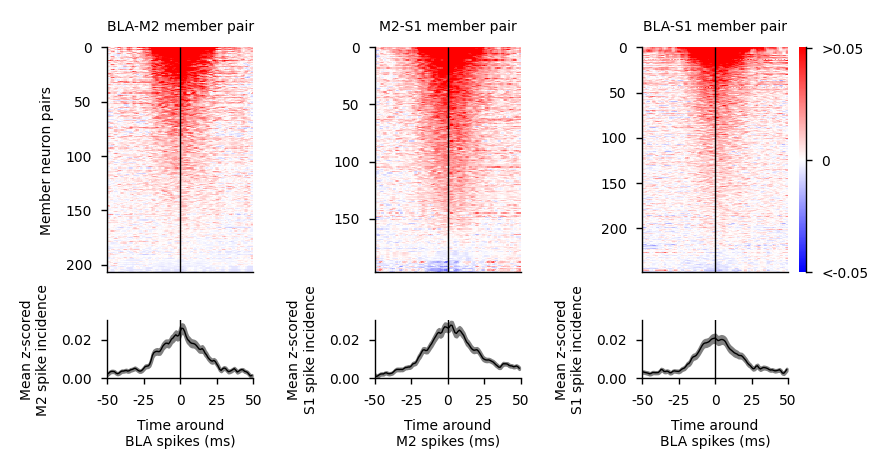

In [309]:
step=25 #ms
sns.set_palette(color)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['axes.edgecolor']='black'
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.labelsize']=5
mpl.rcParams['axes.titlesize']=5
mpl.rcParams['legend.fontsize']=5
mpl.rcParams['xtick.labelsize']=5
mpl.rcParams['ytick.labelsize']=5
mpl.rcParams['text.color']='black'
mpl.rcParams['lines.color']='black'
mpl.rcParams['xtick.color']='black'
mpl.rcParams['ytick.color']='black'
mpl.rcParams['axes.labelcolor']='black'

fig = plt.figure(figsize=(4.75,4),tight_layout=True)
gs = fig.add_gridspec(40, 80)
vmin, vmax=-0.05,0.05
xmin, xmax=reactCorr_BLA_M2.shape[1]/2-50,reactCorr_BLA_M2.shape[1]/2+50
ax1 = fig.add_subplot(gs[0:15, 0:16])
#sns.heatmap(reactCorr_BLA_M2[np.argsort(-np.mean(reactCorr_BLA_M2[:,25:75],axis=1))],vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax1)
sns.heatmap(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1)
            [np.argsort(-np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1)[:,int(reactCorr_BLA_M2.shape[1]/2-25):int(reactCorr_BLA_M2.shape[1]/2+25)],axis=1))]
            ,vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax1)
# sns.heatmap(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1)[np.argsort(np.argmax(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1),axis=1))]
#             ,vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax1)
plt.vlines(x=reactCorr_BLA_M2.shape[1]/2, ymin=0,ymax=reactCorr_BLA_M2.shape[0], color='black', linewidth=0.5)
plt.xlim(xmin, xmax)
ax1.axes.xaxis.set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().spines['bottom'].set_visible(True)
plt.yticks(np.arange(0, reactCorr_BLA_M2.shape[0], 50),np.arange(0, reactCorr_BLA_M2.shape[0], 50))
plt.ylabel('Member neuron pairs')
plt.title('BLA-M2 member pair')
#plt.title('react. CCGs')

ax2 = fig.add_subplot(gs[0:15, 29:45])
# sns.heatmap(reactCorr_M2_S1[np.argsort(-np.mean(reactCorr_M2_S1[:,25:75],axis=1))],vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax2)
sns.heatmap(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1)
            [np.argsort(-np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1)[:,int(reactCorr_M2_S1.shape[1]/2-25):int(reactCorr_M2_S1.shape[1]/2+25)],axis=1))]
            ,vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax2)
# sns.heatmap(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1)[np.argsort(np.argmax(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1),axis=1))]
#             ,vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax2)
plt.vlines(x=reactCorr_M2_S1.shape[1]/2, ymin=0,ymax=reactCorr_M2_S1.shape[0], color='black', linewidth=0.5)
plt.xlim(xmin, xmax)
ax2.axes.xaxis.set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().spines['bottom'].set_visible(True)
plt.yticks(np.arange(0, reactCorr_M2_S1.shape[0], 50),np.arange(0, reactCorr_M2_S1.shape[0], 50))
plt.title('M2-S1 member pair')
#plt.title('react. CCGs')

ax3 = fig.add_subplot(gs[0:15, 58:74])
# sns.heatmap(reactCorr_BLA_S1[np.argsort(-np.mean(reactCorr_BLA_S1[:,25:75],axis=1))],vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax3)
sns.heatmap(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1)
            [np.argsort(-np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1)[:,int(reactCorr_BLA_S1.shape[1]/2-25):int(reactCorr_BLA_S1.shape[1]/2+25)],axis=1))]
            ,vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax3)
# sns.heatmap(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1)[np.argsort(np.argmax(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1),axis=1))]
#             ,vmin=vmin,vmax=vmax, cbar=False, cmap='bwr',ax=ax3)
plt.vlines(x=reactCorr_BLA_S1.shape[1]/2, ymin=0,ymax=reactCorr_BLA_S1.shape[0], color='black', linewidth=0.5)
plt.xlim(xmin, xmax)
ax3.axes.xaxis.set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().spines['bottom'].set_visible(True)
plt.yticks(np.arange(0, reactCorr_BLA_S1.shape[0], 50),np.arange(0, reactCorr_BLA_S1.shape[0], 50))
plt.title('BLA-S1 member pair')
#plt.title('react. CCGs')

ax7 = fig.add_subplot(gs[0:15, 75:76])
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient)).T

ax7.imshow(gradient, aspect=0.25, cmap=plt.cm.bwr_r)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(True)
plt.gca().yaxis.set_ticks_position('right')
plt.yticks([0,128,256],['>'+str(vmax),'0', '<'+str(vmin)])
ax7.axes.xaxis.set_visible(False)

ymin,ymax=0,0.03
ax4 = fig.add_subplot(gs[18:22, 0:16])
#plt.plot(np.mean(reactCorr_BLA_M2,axis=0), color='black', linewidth=0.5)
plt.plot(np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1),axis=0),color='black', linewidth=0.5)
ax4.fill_between(np.arange(xmin,  xmax), np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1),axis=0)-stats.sem(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1)),
                 np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1),axis=0)+stats.sem(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_M2, sigma=1)), color='gray')
plt.vlines(x=reactCorr_BLA_M2.shape[1]/2, ymin=ymin,ymax=reactCorr_BLA_M2.shape[0], color='black', linewidth=0.5)
# ax4.axvspan(xmin+25, reactCorr_BLA_M2.shape[1]/2, color = '#ff8c00', alpha=0.5, lw=0)
# ax4.axvspan(reactCorr_BLA_M2.shape[1]/2,xmax-25, color = '#6a5acd', alpha=0.5, lw=0)
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)
plt.xticks(np.arange(xmin,  xmax+1, step), ['-50', '-25', '0','25', '50'], rotation=0);
#plt.yticks(np.arange(0, 0.06, 0.03),np.arange(0, 0.06, 0.03))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel('Time around\nBLA spikes (ms)')
plt.ylabel('Mean z-scored\nM2 spike incidence')

ax5 = fig.add_subplot(gs[18:22, 29:45])
#plt.plot(np.mean(reactCorr_M2_S1,axis=0), color='black', linewidth=0.5)
plt.plot(np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1),axis=0),color='black', linewidth=0.5)
ax5.fill_between(np.arange(xmin,  xmax), np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1),axis=0)-stats.sem(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1)),
                 np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1),axis=0)+stats.sem(scipy.ndimage.filters.gaussian_filter(reactCorr_M2_S1, sigma=1)), color='gray')
plt.vlines(x=reactCorr_M2_S1.shape[1]/2, ymin=ymin,ymax=reactCorr_M2_S1.shape[0], color='black', linewidth=0.5)
# ax5.axvspan(xmin+25, reactCorr_M2_S1.shape[1]/2, color = '#ff8c00', alpha=0.5, lw=0)
# ax5.axvspan(reactCorr_M2_S1.shape[1]/2,xmax-25, color = '#6a5acd', alpha=0.5, lw=0)
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)
plt.xticks(np.arange(xmin,  xmax+1, step), ['-50', '-25', '0','25', '50'], rotation=0);
#plt.yticks(np.arange(0, 0.06, 0.03),np.arange(0, 0.06, 0.03))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel('Time around\nM2 spikes (ms)')
plt.ylabel('Mean z-scored\nS1 spike incidence')

ax6 = fig.add_subplot(gs[18:22, 58:74])
#plt.plot(np.mean(reactCorr_BLA_S1,axis=0), color='black', linewidth=0.5)
plt.plot(np.nanmean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1),axis=0),color='black', linewidth=0.5)
ax6.fill_between(np.arange(xmin,  xmax), np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1),axis=0)-stats.sem(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1)),
                 np.mean(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1),axis=0)+stats.sem(scipy.ndimage.filters.gaussian_filter(reactCorr_BLA_S1, sigma=1)), color='gray')
plt.vlines(x=reactCorr_BLA_S1.shape[1]/2, ymin=ymin,ymax=reactCorr_BLA_S1.shape[0], color='black', linewidth=0.5)
# ax6.axvspan(xmin+25, reactCorr_BLA_S1.shape[1]/2, color = '#ff8c00', alpha=0.5, lw=0)
# ax6.axvspan(reactCorr_BLA_S1.shape[1]/2,xmax-25, color = '#6a5acd', alpha=0.5, lw=0)
plt.xlim(xmin, xmax)
plt.ylim(ymin,ymax)
plt.xticks(np.arange(xmin,  xmax+1, step), ['-50', '-25', '0','25', '50'], rotation=0);
#plt.yticks(np.arange(0, 0.06, 0.03),np.arange(0, 0.06, 0.03))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.xlabel('Time around\nBLA spikes (ms)')
plt.ylabel('Mean z-scored\nS1 spike incidence')

axpos1 = ax1.get_position() 
axpos4 = ax4.get_position() 
ax4.set_position([axpos4.x0, axpos4.y0, axpos1.width, axpos4.height])

axpos2 = ax2.get_position() 
axpos5 = ax5.get_position() 
ax5.set_position([axpos5.x0, axpos5.y0, axpos2.width, axpos5.height])

axpos3 = ax3.get_position() 
ax3.set_position([axpos3.x0, axpos3.y0, axpos1.width, axpos1.height])
axpos6 = ax6.get_position() 
ax6.set_position([axpos6.x0, axpos6.y0, axpos1.width, axpos6.height])
plt.savefig(res_Dir+'/ReactCCG_NREM_30min_wFemale.pdf',dpi=fig.dpi,bbox_inches='tight')

In [300]:
def prepareReactTrial(predictor, predicted, React_Event, binwidth, binwidth_fine):
    import sklearn
    React_Event = (React_Event*binwidth/binwidth_fine).astype('int64') #convert to fine sampling rate 
    # delete React_Event index outside window
    del_id_pre = np.where((React_Event-binwidth_fine)<=0)
    React_Event = np.delete(React_Event, del_id_pre)

    del_id_post = np.where((React_Event+binwidth_fine)>predictor.shape[1])
    React_Event = np.delete(React_Event, del_id_post)

    # number of React_Event
    nReact = React_Event.shape[0] 

    react_window_idx = np.vstack([React_Event, React_Event+(binwidth/binwidth_fine)]).T.astype('int64')
    # predictor = np.append(predictor,[np.ones(predictor.shape[1])],axis=0)
    predictor_mtx = []
    predicted_mtx = []
    for i in range(nReact):
        a = np.sum(predictor[:,react_window_idx[i][0]:react_window_idx[i][1]],axis=1)
        b = np.sum(predicted[:,react_window_idx[i][0]:react_window_idx[i][1]],axis=1)
        predictor_mtx.append(a)
        predicted_mtx.append(b)
    predictor_mtx = np.array(predictor_mtx)
    predicted_mtx = np.array(predicted_mtx)
    
    #constant =1 
    predictor_mtx = np.hstack((predictor_mtx, np.ones(predictor_mtx.shape[0]).reshape(predictor_mtx.shape[0],1)))
    
    ## Create Shuffled Data
    predicted_mtx_shuffled=sklearn.utils.shuffle(predicted_mtx)

    TrialMatrix = {'predictor': predictor_mtx, 'predicted': predicted_mtx, 'predicted_shuffled': predicted_mtx_shuffled}

    return TrialMatrix

In [301]:
def spikeGLMReact(TrialMatrix):
    from sklearn.model_selection import KFold
    import statsmodels.api as sm
    nTrials = np.arange(TrialMatrix['predictor'].shape[0])
    kf = KFold(n_splits = 5, shuffle = True)
    nCells = TrialMatrix['predicted'].shape[1]

    prediction_gain = []
    prediction_gain_shfl = []
    for k in range(nCells):
        prediction_gain_tmp2=[]
        prediction_gain_shfl_tmp2=[]
        for i in range(100): # repeat 100 times
            prediction_gain_tmp = []
            prediction_gain_shfl_tmp = []
            for train_index, test_index in kf.split(nTrials):
                y_trn = TrialMatrix['predicted'][train_index]
                y_test = TrialMatrix['predicted'][test_index]

                x_trn = TrialMatrix['predictor'][train_index]
                x_test = TrialMatrix['predictor'][test_index]

                y_trn_shfl =  TrialMatrix['predicted_shuffled'][train_index]
                y_test_shfl = TrialMatrix['predicted_shuffled'][test_index]

                # create an instance of the GLM class
                if np.where(y_trn[:,k]>0)[0]!=[]:
                    link = sm.genmod.families.links.log
                    glm = sm.GLM(endog=y_trn[:,k], exog=x_trn, family=sm.families.Poisson(link=link))
                    result = glm.fit()

                    glm_shfl = sm.GLM(endog=y_trn_shfl[:,k], exog=x_trn, family=sm.families.Poisson(link=link))
                    result_shfl = glm_shfl.fit()

                    # predict using fitted model on the test data
                    yhat = result.predict(x_test)
                    yhat_shfl = result_shfl.predict(x_test)

                    #calculate prediction error
                    # diff = np.mean(abs(y_test[:,k]-yhat))
                    # diff_sfhl = np.mean(abs(y_test_shfl[:,k]-yhat_shfl))
                    diff = np.mean(abs(y_test[:,k]/np.max(y_test[:,k])-yhat))
                    diff_sfhl = np.mean(abs(y_test_shfl[:,k]/np.max(y_test_shfl[:,k])-yhat_shfl))
                    #calculate shuffled prediction error
                    # diff_shuff = np.mean(abs(y_test[:,k]-np.random.permutation(yhat)))
                    # diff_shuff_sfhl = np.mean(abs(y_test_shfl[:,k]-np.random.permutation(yhat_shfl)))
                    diff_shuff = np.mean(abs(y_test[:,k]/np.max(y_test[:,k])-np.random.permutation(yhat)))
                    diff_shuff_sfhl = np.mean(abs(y_test_shfl[:,k]/np.max(y_test_shfl[:,k])-np.random.permutation(yhat_shfl)))
                    #calculate prediction gain
                    prediction_gain_raw = diff_shuff/diff
                    prediction_gain_tmp.append(prediction_gain_raw)
                    prediction_gain_raw_shfl = diff_shuff_sfhl/diff_sfhl
                    prediction_gain_shfl_tmp.append(prediction_gain_raw_shfl)
                else:
                    prediction_gain_tmp = [np.nan]
                    prediction_gain_shfl_tmp = [np.nan]

            prediction_gain_tmp = np.nanmean(prediction_gain_tmp)
            prediction_gain_shfl_tmp = np.nanmean(prediction_gain_shfl_tmp)
            prediction_gain_tmp2.append(prediction_gain_tmp)
            prediction_gain_shfl_tmp2.append(prediction_gain_shfl_tmp)
        prediction_gain.append(np.nanmean(prediction_gain_tmp2))
        prediction_gain_shfl.append(np.nanmean(prediction_gain_shfl_tmp2))

    prediction_gain = np.array(prediction_gain)
    prediction_gain_shfl  = np.array(prediction_gain_shfl)

    return prediction_gain, prediction_gain_shfl

In [302]:
%%time
prediction_gain_BLA_M2_all = []
prediction_gain_M2_BLA_all = []
prediction_gain_M2_S1_all = []
prediction_gain_S1_M2_all = []
prediction_gain_BLA_S1_all = []
prediction_gain_S1_BLA_all = []

prediction_gain_BLA_M2_shfl_all = []
prediction_gain_M2_BLA_shfl_all = []
prediction_gain_M2_S1_shfl_all = []
prediction_gain_S1_M2_shfl_all = []
prediction_gain_BLA_S1_shfl_all = []
prediction_gain_S1_BLA_shfl_all = []

for mouseID in mouseID_wf:
    count_BLA_M2_S1 = 0
    for asmblyID in Assembly_all[mouseID].keys():
        if Assembly_all[mouseID][asmblyID]['Type'] == 'BLA-M2-S1':
            count_BLA_M2_S1=count_BLA_M2_S1+1
    if count_BLA_M2_S1!=0:
        binwidth_fine = 0.025
        binraster_fine_Dir = glob.glob('/home/ysaito/Synology/Saito/Tetrode/02_Analysis/Analysis_All/01_UnitProcess/binraster_'+str(int(binwidth_fine*1000))+'ms')[0]
        binraster_fine_BLA = binrasterLoad(mouseID = mouseID, region = 'BLA', binraster_Dir=binraster_fine_Dir, unitType='All')
        binraster_fine_M2 = binrasterLoad(mouseID = mouseID, region = 'M2', binraster_Dir=binraster_fine_Dir, unitType='All')
        binraster_fine_S1 = binrasterLoad(mouseID = mouseID, region = 'S1', binraster_Dir=binraster_fine_Dir, unitType='All')

        epoch_state = 'POST_NREM'
        binraster_A = binraster_fine_BLA[epoch_state][:,:int(1800/binwidth_fine)]
        binraster_B = binraster_fine_M2[epoch_state][:,:int(1800/binwidth_fine)]
        binraster_C = binraster_fine_S1[epoch_state][:,:int(1800/binwidth_fine)]
        binraster_fine_All = np.vstack([binraster_A, binraster_B, binraster_C])
        
        prediction_gain_BLA_M2_tmp = []
        prediction_gain_M2_BLA_tmp = []
        prediction_gain_M2_S1_tmp = []
        prediction_gain_S1_M2_tmp = []
        prediction_gain_BLA_S1_tmp = []
        prediction_gain_S1_BLA_tmp = []
        
        prediction_gain_BLA_M2_shfl_tmp = []
        prediction_gain_M2_BLA_shfl_tmp = []
        prediction_gain_M2_S1_shfl_tmp = []
        prediction_gain_S1_M2_shfl_tmp = []
        prediction_gain_BLA_S1_shfl_tmp = []
        prediction_gain_S1_BLA_shfl_tmp = []
        
        for assembly_idx in Assembly_all[mouseID].keys():
            if Assembly_all[mouseID][assembly_idx]['Type'] == 'BLA-M2-S1':
                
                React_Event =detectReactivation(Assembly_all[mouseID][assembly_idx]['RpostNREM'][:int(1800/binwidth)]) #first 30min
                React_Event_rand=np.sort(np.random.randint(0, int(1800/binwidth),React_Event.shape[0])) #first 30min
                binraster_mmbr_BLA = binraster_fine_All[Assembly_all[mouseID][assembly_idx]['member']['BLA']]
                binraster_mmbr_M2 = binraster_fine_All[Assembly_all[mouseID][assembly_idx]['member']['M2']]
                binraster_mmbr_S1 = binraster_fine_All[Assembly_all[mouseID][assembly_idx]['member']['S1']]
        
                React_Event =detectReactivation(Assembly_all[mouseID][assembly_idx]['RpostNREM'][:int(1800/binwidth)]) #first 30min

                TrialMatrix_BLA_M2 = prepareReactTrial(binraster_mmbr_BLA, binraster_mmbr_M2, React_Event, binwidth, binwidth_fine)       
                TrialMatrix_M2_BLA = prepareReactTrial(binraster_mmbr_M2, binraster_mmbr_BLA, React_Event, binwidth, binwidth_fine)

                TrialMatrix_M2_S1 = prepareReactTrial(binraster_mmbr_M2, binraster_mmbr_S1, React_Event, binwidth, binwidth_fine)
                TrialMatrix_S1_M2 = prepareReactTrial(binraster_mmbr_S1, binraster_mmbr_M2, React_Event, binwidth, binwidth_fine)


                TrialMatrix_BLA_S1 = prepareReactTrial(binraster_mmbr_BLA, binraster_mmbr_S1, React_Event, binwidth, binwidth_fine)
                TrialMatrix_S1_BLA = prepareReactTrial(binraster_mmbr_S1, binraster_mmbr_BLA, React_Event, binwidth, binwidth_fine)

                # GLM
                #BLA-M2
                prediction_gain_BLA_M2, prediction_gain_BLA_M2_shfl = spikeGLMReact(TrialMatrix_BLA_M2)
                prediction_gain_M2_BLA, prediction_gain_M2_BLA_shfl = spikeGLMReact(TrialMatrix_M2_BLA)
                #M2-S1
                prediction_gain_M2_S1, prediction_gain_M2_S1_shfl = spikeGLMReact(TrialMatrix_M2_S1)
                prediction_gain_S1_M2, prediction_gain_S1_M2_shfl = spikeGLMReact(TrialMatrix_S1_M2)
                #BLA-S1
                prediction_gain_BLA_S1, prediction_gain_BLA_S1_shfl = spikeGLMReact(TrialMatrix_BLA_S1)
                prediction_gain_S1_BLA, prediction_gain_S1_BLA_shfl = spikeGLMReact(TrialMatrix_S1_BLA)


                prediction_gain_BLA_M2_tmp.extend(prediction_gain_BLA_M2)
                prediction_gain_M2_BLA_tmp.extend(prediction_gain_M2_BLA)
                prediction_gain_M2_S1_tmp.extend(prediction_gain_M2_S1)
                prediction_gain_S1_M2_tmp.extend(prediction_gain_S1_M2)
                prediction_gain_BLA_S1_tmp.extend(prediction_gain_BLA_S1)
                prediction_gain_S1_BLA_tmp.extend(prediction_gain_S1_BLA)

                prediction_gain_BLA_M2_shfl_tmp.extend(prediction_gain_BLA_M2_shfl)
                prediction_gain_M2_BLA_shfl_tmp.extend(prediction_gain_M2_BLA_shfl)
                prediction_gain_M2_S1_shfl_tmp.extend(prediction_gain_M2_S1_shfl)
                prediction_gain_S1_M2_shfl_tmp.extend(prediction_gain_S1_M2_shfl)
                prediction_gain_BLA_S1_shfl_tmp.extend(prediction_gain_BLA_S1_shfl)
                prediction_gain_S1_BLA_shfl_tmp.extend(prediction_gain_S1_BLA_shfl)


        prediction_gain_BLA_M2_all.extend(prediction_gain_BLA_M2_tmp)
        prediction_gain_M2_BLA_all.extend(prediction_gain_M2_BLA_tmp)
        prediction_gain_M2_S1_all.extend(prediction_gain_M2_S1_tmp)
        prediction_gain_S1_M2_all.extend(prediction_gain_S1_M2_tmp)
        prediction_gain_BLA_S1_all.extend(prediction_gain_BLA_S1_tmp)
        prediction_gain_S1_BLA_all.extend(prediction_gain_S1_BLA_tmp)

        prediction_gain_BLA_M2_shfl_all.extend(prediction_gain_BLA_M2_shfl_tmp)
        prediction_gain_M2_BLA_shfl_all.extend(prediction_gain_M2_BLA_shfl_tmp)
        prediction_gain_M2_S1_shfl_all.extend(prediction_gain_M2_S1_shfl_tmp)
        prediction_gain_S1_M2_shfl_all.extend(prediction_gain_S1_M2_shfl_tmp)
        prediction_gain_BLA_S1_shfl_all.extend(prediction_gain_BLA_S1_shfl_tmp)
        prediction_gain_S1_BLA_shfl_all.extend(prediction_gain_S1_BLA_shfl_tmp)

TM015 BLA_RS 25
TM015 BLA_FS No units
TM015 M2_RS 8
TM015 M2_FS No units
TM015 S1_RS 10
TM015 S1_FS 1
TM028 BLA_RS 8
TM028 BLA_FS No units
TM028 M2_RS 4
TM028 M2_FS 2
TM028 S1_RS 11
TM028 S1_FS 1
TM033 BLA_RS 5
TM033 BLA_FS 1
TM033 M2_RS 11
TM033 M2_FS 1
TM033 S1_RS 4
TM033 S1_FS No units
TM037 BLA_RS 5
TM037 BLA_FS 1
TM037 M2_RS 20
TM037 M2_FS No units
TM037 S1_RS 13
TM037 S1_FS 3
CPU times: user 1h 18min 23s, sys: 3h 52min 29s, total: 5h 10min 52s
Wall time: 30min 25s


In [303]:
mean =[np.mean(prediction_gain_BLA_M2_all), np.mean(prediction_gain_M2_BLA_all),
       np.mean(prediction_gain_M2_S1_all), np.mean(prediction_gain_S1_M2_all),
       np.mean(prediction_gain_BLA_S1_all), np.mean(prediction_gain_S1_BLA_all)]
sem = [stats.sem(prediction_gain_BLA_M2_all), stats.sem(prediction_gain_M2_BLA_all), 
       stats.sem(prediction_gain_M2_S1_all), stats.sem(prediction_gain_S1_M2_all), 
       stats.sem(prediction_gain_BLA_S1_all), stats.sem(prediction_gain_S1_BLA_all)]
mean_shfl = [np.mean(prediction_gain_BLA_M2_shfl_all), np.mean(prediction_gain_M2_BLA_shfl_all),
             np.mean(prediction_gain_M2_S1_shfl_all), np.mean(prediction_gain_S1_M2_shfl_all),
             np.mean(prediction_gain_BLA_S1_shfl_all), np.mean(prediction_gain_S1_BLA_shfl_all)]
sem_shfl = [stats.sem(prediction_gain_BLA_M2_shfl_all), stats.sem(prediction_gain_M2_BLA_shfl_all), 
            stats.sem(prediction_gain_M2_S1_shfl_all), stats.sem(prediction_gain_S1_M2_shfl_all),
            stats.sem(prediction_gain_BLA_S1_shfl_all), stats.sem(prediction_gain_S1_BLA_shfl_all)]

In [305]:
print(stats.mannwhitneyu(prediction_gain_BLA_M2_all, prediction_gain_BLA_M2_shfl_all, alternative='two-sided'))
print(stats.mannwhitneyu(prediction_gain_M2_BLA_all, prediction_gain_M2_BLA_shfl_all, alternative='two-sided'))

print(stats.mannwhitneyu(prediction_gain_M2_S1_all, prediction_gain_M2_S1_shfl_all, alternative='two-sided'))
print(stats.mannwhitneyu(prediction_gain_S1_M2_all, prediction_gain_S1_M2_shfl_all, alternative='two-sided'))

print(stats.mannwhitneyu(prediction_gain_BLA_S1_all, prediction_gain_BLA_S1_shfl_all, alternative='two-sided'))
print(stats.mannwhitneyu(prediction_gain_S1_BLA_all, prediction_gain_S1_BLA_shfl_all, alternative='two-sided'))

MannwhitneyuResult(statistic=3036.5, pvalue=1.3122865724582731e-17)
MannwhitneyuResult(statistic=4554.0, pvalue=2.1778731819111944e-20)
MannwhitneyuResult(statistic=4147.5, pvalue=2.5413929836525884e-17)
MannwhitneyuResult(statistic=3046.0, pvalue=8.12093604245108e-18)
MannwhitneyuResult(statistic=4260.0, pvalue=3.059956039081699e-19)
MannwhitneyuResult(statistic=4540.0, pvalue=3.7982177444254723e-20)


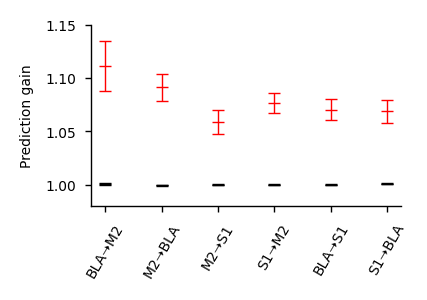

In [310]:
sns.set_palette(color)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['axes.edgecolor']='black'
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.size'] = 5
mpl.rcParams['axes.labelsize']=5
mpl.rcParams['axes.titlesize']=5
mpl.rcParams['legend.fontsize']=5
mpl.rcParams['xtick.labelsize']=5
mpl.rcParams['ytick.labelsize']=5
mpl.rcParams['text.color']='black'
mpl.rcParams['lines.color']='black'
mpl.rcParams['xtick.color']='black'
mpl.rcParams['ytick.color']='black'
mpl.rcParams['axes.labelcolor']='black'

plt.figure(figsize=(2,1.2))
boxprops = {'edgecolor': 'black', 'linewidth': 0.5}
lineprops = {'color': 'black', 'linewidth': 0.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75})
# sns.boxplot(data=predictiongain_all, x='Direction', y='prediction gain', color='gray', **boxplot_kwargs)
plt.errorbar(x=[0,1,2,3,4,5], y=mean, yerr=sem, fmt = "_", color = "red", capsize = 2, markersize = 4, markeredgewidth =0.5, elinewidth = 0.5)
plt.errorbar(x=[0,1,2,3,4,5], y=mean_shfl, yerr=sem_shfl, fmt = "_", color = "black", capsize = 2, markersize = 4, markeredgewidth = 0.5, elinewidth = 0.5)
plt.xticks([0,1,2,3,4,5],['BLA➝M2', 'M2➝BLA', 'M2➝S1', 'S1➝M2', 'BLA➝S1', 'S1➝BLA'],rotation=60);
plt.ylabel('Prediction gain')
plt.ylim(0.98, 1.15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')
plt.savefig(res_Dir+'/React_glm.pdf',dpi=fig.dpi,bbox_inches='tight')